## Chess bot

### For this project I wanted to try something new and train a neural network, to use it in a chessbot.
### The neural network will be trained with a dataset from Kaggle that has positions in chess and their evaluation from the chess engine stockfish.
#### The focus is mainly to figure out an input to train the model and to get some kind of evaluation. To make a proper chessbot there needs to be more coding in here, in order to take in account all of the rules and other more subtle things, like the transitions between opening, middle game and endgame (for example the evaluation of the position of the king varies drastically if there are no major pieces in the board anymore). 

In [2]:
import chess
import chess.engine
import random
import numpy
from IPython.display import SVG, display, clear_output
from tensorflow.keras import models
import chess.svg
from chessboard import display

# this function will create our x (board)
def random_board(max_depth=200):
    board = chess.Board()
    depth = random.randrange(0, max_depth)

    for _ in range(depth):
        all_moves = list(board.legal_moves)
        random_move = random.choice(all_moves)
        board.push(random_move)
        if board.is_game_over():
            break

    return board


# this function will create our f(x) (score) in order to use this you need to download stockfish and specify the path below
def stockfish(board, depth):
    with chess.engine.SimpleEngine.popen_uci('stockfish-windows-x86-64-avx2.exe') as sf:
        result = sf.analyse(board, chess.engine.Limit(depth=depth))
        score = result['score'].white().score()
    return score, result

# Creating the input for our training

There are many ways of inputing information into the network. Since the chessboard is 8 x 8, this will define the matrix size. Also, there will be a number of layers of that size that will contain the representation of each of the 6 different pieces, so 12 layers (6 for white, 6 for black). Finally there will be 2 more layers, each representing the spaces that can be occupied by each player in the next turn, so it the 'available moves'. 

On a quick note: after reviewing some material, it is clear that this is not enough information to feed to the model. As an example, the chess engine Alpha Zero had 119 different inputs to train the model. This is not really realistic for a project of this size, and will not be feasible from a computational point of view either.

So I will take a dataset that contains around 900k positions and their evaluation from stockfish. Then each position will be decomposed into a 3d matrix of size **8 x 8 x 14** into a tensor. I will use TensorFlow to train the model.

In [11]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}



def square_to_index(square):
    letter = chess.square_name(square)
    return 8 - int(letter[1]), squares_index[letter[0]]

#function that creates the matrix, and adds the positions as explained above
def split_dims(board):
    
    board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

    
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            idx = numpy.unravel_index(square, (8, 8))
            board3d[piece - 1][7 - idx[0]][idx[1]] = 1
        for square in board.pieces(piece, chess.BLACK):
            idx = numpy.unravel_index(square, (8, 8))
            board3d[piece + 5][7 - idx[0]][idx[1]] = 1

    # these are the last 2 layers as explained above
    #possible moves in a position
    aux = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board3d[12][i][j] = 1
    board.turn = chess.BLACK
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board3d[13][i][j] = 1
    board.turn = aux

    return board3d

In [12]:
import numpy as np
import pandas as pd
#df = pd.read_csv('random_evals.csv')

In [55]:
df = df[~df['Evaluation'].str.contains('#')]

In [61]:
df['Evaluation'] = df['Evaluation'].astype('float')

C:\Users\guine\AppData\Local\Temp\ipykernel_49204\4019087422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Evaluation'] = df['Evaluation'].astype('float')


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 944009 entries, 0 to 1000272
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   FEN         944009 non-null  object 
 1   Evaluation  944009 non-null  float64
dtypes: float64(1), object(1)
memory usage: 21.6+ MB


In [24]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [21]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers


def build_model(conv_size, conv_depth):
    #creates an input layer for a 3D board with shape (14, 8, 8). This assumes that your input data represents 
    #a 3D board with dimensions 14x8x8.
    board3d = layers.Input(shape=(14, 8, 8))

    # adding the convolutional layers
    x = board3d
    for _ in range(conv_depth):
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Dense(64, 'relu')(x)
        
    #flatten the layers after the loop
    x = layers.Flatten()(x)
    x = layers.Dense(1, 'sigmoid')(x)
    return models.Model(inputs=board3d, outputs=x)

I have tried 2 versions of a model with different activation layers and then a residual model. This part is pretty interesting as I have not worked with neural networks before and I would like to understand them better for a future project.

In [ ]:
from tensorflow.keras import layers, models

def build_model(conv_size, conv_depth):
    board3d = layers.Input(shape=(14, 8, 8))

    x = board3d

    for _ in range(conv_depth):
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)

    # Output layer with a single unit for evaluation
    evaluation_output = layers.Dense(1, activation='linear')(x)

    return models.Model(inputs=board3d, outputs=evaluation_output)

In [164]:
def build_model_residual(conv_size, conv_depth):
    board3d = layers.Input(shape=(14, 8, 8))

    # adding the convolutional layers
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(board3d)
    for _ in range(conv_depth):
        previous = x
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, previous])
        x = layers.Activation('relu')(x)
    #flatten and add the dense layer after the loop
    
    evaluation_output = layers.Dense(1, activation='linear')(x)
    
    return models.Model(inputs=board3d, outputs=evaluation_output)

In [170]:
model = build_model_residual(32, 2)

# Training

In [ ]:
import tensorflow.keras.callbacks as callbacks


def get_dataset():
    container = numpy.load('dataset.npz')
    b, v = container['b'], container['v']
    v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1)
    return b, v


x_train, y_train = get_dataset()
x_train.transpose()
print(x_train.shape)
print(y_train.shape)

### modified version

In [ ]:
# Example function to convert FEN string to 3D matrix and include evaluation
def fen_to_3d_matrix(fen, evaluation):
    # Replace this function with your actual implementation
    # Example: converting FEN to a random 3D matrix for demonstration
    matrix_3d = np.random.random((14, 8, 8))
    
    # Convert the evaluation string to a float
    evaluation_value = float(evaluation) if evaluation not in ['-inf', 'inf'] else np.nan
    
    return matrix_3d, evaluation_value

# Example dataset
data = {'FEN': ['rnbqkb1r/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR',
                'rnbqkb1r/pppppppp/8/4P3/8/8/PPP2PPP/RNBQKBNR'],
        'Evaluation': ['0.5', '-inf']}
df = pd.DataFrame(data)

# Initialize X and y as empty lists to store matrices and evaluations
X = []
y = []

# Iterate through the dataset
for _, row in df.iterrows():
    # Create a chess board object from the FEN string
    board = chess.Board(fen=row['FEN'])
    
    # Use your function to convert the board to a 3D matrix and include evaluation
    matrix_3d = split_dims(board)
    evaluation_value = row['Evaluation']
    # Append the 3D matrix to X and evaluation to y
    X.append(matrix_3d)
    y.append(evaluation_value)

In [ ]:
X = []
y = []

# Iterate through the dataset
for _, row in df.iterrows():
    # Create a chess board object from the FEN string
    board = chess.Board(fen=row['FEN'])
    
    # Use your function to convert the board to a 3D matrix and include evaluation
    matrix_3d = split_dims(board)
    evaluation_value = row['Evaluation']
    # Append the 3D matrix to X and evaluation to y
    X.append(matrix_3d)
    y.append(evaluation_value)

In [ ]:
X_train = np.array(X)
y_train = np.array(y)

In [177]:
#model = build_model(32, 2)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Assuming X_train is your input data (3D board) and y_train is your evaluation scores
model.fit(X_train, y_train, epochs=10, batch_size=4096, validation_split=0.2)

Epoch 1/10
185/185 [==============================] - 1311s 7s/step - loss: 1100484.5000 - mae: 596.9105 - val_loss: 1297358.8750 - val_mae: 638.7561
Epoch 2/10
185/185 [==============================] - 1310s 7s/step - loss: 1100359.0000 - mae: 596.9371 - val_loss: 1297737.8750 - val_mae: 638.8719
Epoch 3/10
185/185 [==============================] - 1310s 7s/step - loss: 1100320.1250 - mae: 596.9948 - val_loss: 1298009.7500 - val_mae: 638.9951
Epoch 4/10
185/185 [==============================] - 1309s 7s/step - loss: 1100312.8750 - mae: 597.0662 - val_loss: 1298127.2500 - val_mae: 639.0480
Epoch 5/10
185/185 [==============================] - 1315s 7s/step - loss: 1100311.8750 - mae: 597.0443 - val_loss: 1298181.3750 - val_mae: 639.0777
Epoch 6/10
185/185 [==============================] - 1313s 7s/step - loss: 1100312.1250 - mae: 597.0804 - val_loss: 1298163.0000 - val_mae: 639.0667
Epoch 7/10
185/185 [==============================] - 1312s 7s/step - loss: 1100311.7500 - mae: 597.

In [71]:
# I have trained the model
#lets save it first!
model.save('model_1')

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


In [156]:
# Create a chess board object from the FEN string
#board_for_prediction = chess.Board(fen=fen_for_prediction)

# Assuming you have a trained model saved in a file (modify the path accordingly)
#model_path = 'path/to/your/trained_model.h5'
#model = load_model(model_path)
board = random_board()

# Use your function to convert the board to a 3D matrix for prediction
matrix_3d_for_prediction, _ = split_dims(board), '0.0'  # Use a placeholder evaluation value

# Reshape the input to match the model's expected input shape
input_for_prediction = matrix_3d_for_prediction.reshape((1,) + matrix_3d_for_prediction.shape)

# Make a prediction
prediction = model.predict(input_for_prediction)

1/1 [==============================] - 0s 13ms/step


In [157]:
print("Predicted Value:", prediction[0, 0])


Predicted Value: 0.0


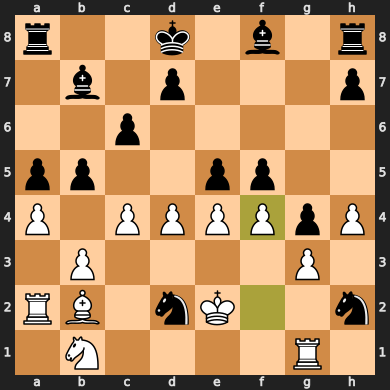

In [158]:
board

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()
checkpoint_filepath = '/tmp/checkpoint/'
model_checkpointing_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only= True,
)
model.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4),model_checkpointing_callback])

model.save('model.h5')

# Completing the chessbot to play

After training I am going to use model_1 to give me the evaluation of a position. I need to add the other functions that will make up the chess bot. With minimax and alpha beta pruning the position with a better evaluation will be selected. But because of computational power, having a depth more than 2 will make it very very slow. Also the functions added are very simple and the resulting bot will not be very good. The focus was more on the previous parts as it was pretty interesting to see how to train and how to obtain the data for the context of chess. But seeing the bot play is a must.

In [73]:
from tensorflow.keras import models
model = models.load_model('model_1')

In [74]:
# used for the minimax algorithm
def minimax_eval(board):
    board3d = split_dims(board)
    board3d = numpy.expand_dims(board3d, 0)
    return model(board3d)[0][0]
#I will modify the minimax_eval for my model output in order to get the evaluation.


def minimax(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return minimax_eval(board)

    if maximizing_player:
        max_eval = -numpy.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = numpy.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
    return min_eval


# this is the actual function that gets the move from the neural network
def ai_move(board, depth):
    max_move = None
    max_eval = -numpy.inf

    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            max_move = move

    return max_move

In [167]:
def evaluate_board(board, model):
    # Replace this with your actual model evaluation function
    # Example: using a placeholder for demonstration
    matrix_3d_for_prediction, _ = split_dims(board), '0.0'  # Use a placeholder evaluation value

    # Reshape the input to match the model's expected input shape
    input_for_prediction = matrix_3d_for_prediction.reshape((1,) + matrix_3d_for_prediction.shape)

    # Make a prediction
    prediction = model.predict(input_for_prediction)
    return prediction[0, 0]

In [168]:
import numpy as np

def minimax(board, depth, alpha, beta, maximizing_player, model):
    if depth == 0 or board.is_game_over():
        return evaluate_board(board, model)

    if maximizing_player:
        max_eval = -np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False, model)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True, model)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval




In [169]:
def ai_move(board, depth):
    max_move = None
    max_eval = -numpy.inf

    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            max_move = move

    return max_move

In [24]:
!pip install chess-board

  Obtaining dependency information for chess-board from https://files.pythonhosted.org/packages/e3/68/8691d498c143da725010a51d4e8dea1fa80ad4937fe05fb0b92a6a7276d3/chess_board-0.4.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pygame from https://files.pythonhosted.org/packages/82/61/93ae7afbd931a70510cfdf0a7bb0007540020b8d80bc1d8762ebdc46479b/pygame-2.5.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
    --------------------------------------- 0.2/10.8 MB 6.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.8/10.8 MB 10.6 MB/s eta 0:00:01
   ------ --------------------------------- 1.7/10.8 MB 13.5 MB/s eta 0:00:01
   -------------- ------------------------- 4.0/10.8 MB 23.1 MB/s eta 0:00:01
   --------------------- ------------------ 5.8/10.8 MB 26.7 MB/s eta 0:00:01
   ----------------------------- ---------- 7.9/10.8 MB 29.7 MB/s eta 0:00:01
   ----------------------------------- ---- 9.

In [85]:
#this function makes the bot play against stockfish. It is possible to change the depth in the ai_move function



def record_and_display_moves(board, engine, board_size=600):
    svg_board = chess.svg.board(board=board, size=board_size)
    display(SVG(svg_board))

    moves = []

    with engine:
        while not board.is_game_over():
            move = ai_move(board, 1)
            board.push(move)
            moves.append(move)
            update_board(board, moves, board_size)

            if board.is_game_over():
                print('Game over')
                break
            
            move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
            board.push(move)
            moves.append(move)
            update_board(board, moves, board_size)

    print('Game over')

def update_board(board, moves, board_size):
    svg_board = chess.svg.board(board=board, size=board_size)
    clear_output(wait=True)
    display(SVG(svg_board))




In [79]:
stockfish_path = 'stockfish-windows-x86-64-avx2.exe'



In [ ]:
# this variation enable us to play against the bot instead of stockfish.

def record_and_display_moves_user(board, engine, board_size=600):
    svg_board = chess.svg.board(board=board, size=board_size)
    display(SVG(svg_board))

    moves = []

    while not board.is_game_over():
        move = ai_move(board, 2)  # Use get_ai_move for one player
        board.push(move)
        moves.append(move)
        update_board(board, moves, board_size)

        if board.is_game_over():
            print('Game over')
            break

        move = get_user_move(board)  # Use get_user_move for the other player
        board.push(move)
        moves.append(move)
        update_board(board, moves, board_size)

    print('Game over')

def get_user_move(board):
    while True:
        # Keep prompting until a valid move is entered
        move_uci = input("Enter your move in UCI format (e.g., e2e4): ")
        if is_valid_move(board, move_uci):
            return chess.Move.from_uci(move_uci)
        else:
            print("Invalid move. Please enter a valid move.")

def is_valid_move(board, move_uci):
    try:
        move = chess.Move.from_uci(move_uci)
        return move in board.legal_moves
    except ValueError:
        return False

def update_board(board, moves, board_size):
    svg_board = chess.svg.board(board=board, size=board_size, lastmove=moves[-1])
    clear_output(wait=True)
    display(SVG(svg_board))


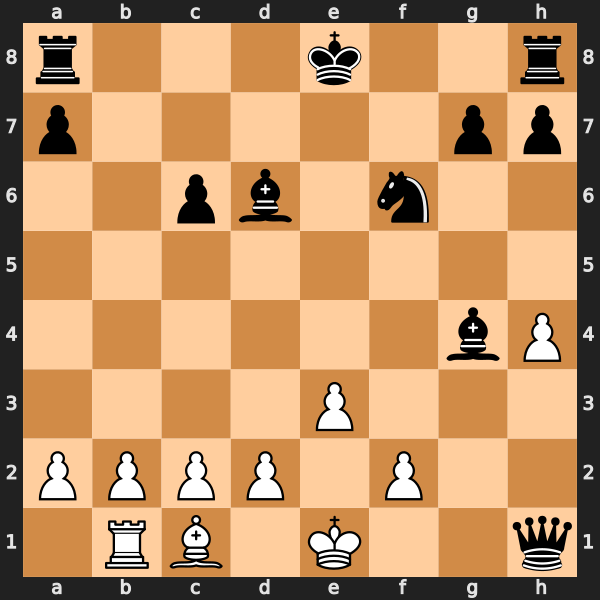

Game over


In [107]:
with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
    initial_board = chess.Board()
    record_and_display_moves(initial_board, engine, board_size=600)

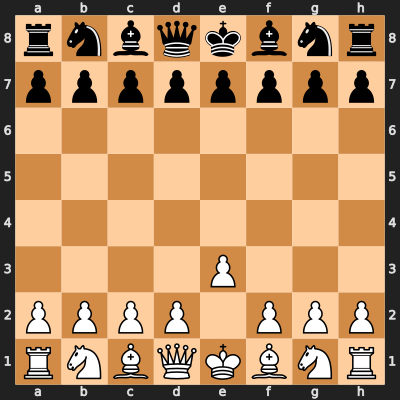

KeyboardInterrupt: Interrupted by user

In [87]:
initial_board = chess.Board()
record_and_display_moves_user(initial_board, engine)